In [1]:
import pandas as pd
import numpy as np
import requests
from io import StringIO
import joblib
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import RandomizedSearchCV
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.metrics import accuracy_score
from tabulate import tabulate
import matplotlib.pyplot as plt

In [2]:
# The URL of the raw dataset on GitHub
url = "https://raw.githubusercontent.com/abactat/BC-Project/main/data/processed/train_data.csv?token=GHSAT0AAAAAACC4ZCNKRKQBWCGNKARGMRZ2ZGRO5TA"

# Send an HTTP GET request to fetch the content of the raw dataset
response = requests.get(url)

# Check if the request was successful (status code 200 means success)
if response.status_code == 200:
    # Read the content as a pandas DataFrame and assign it to the 'train' variable
    train = pd.read_csv(StringIO(response.text))
    print("Dataset downloaded and loaded into 'train' successfully.")
else:
    print(f"Failed to download the dataset. Status code: {response.status_code}")
    
# The URL of the raw dataset on GitHub
url = "https://raw.githubusercontent.com/abactat/BC-Project/main/data/processed/val_data.csv?token=GHSAT0AAAAAACC4ZCNL6CLEYWQ7I647KVRWZGRO57A"

# Send an HTTP GET request to fetch the content of the raw dataset
response = requests.get(url)

# Check if the request was successful (status code 200 means success)
if response.status_code == 200:
    # Read the content as a pandas DataFrame and assign it to the 'valid' variable
    valid = pd.read_csv(StringIO(response.text))
    print("Dataset downloaded and loaded into 'valid' successfully.")
else:
    print(f"Failed to download the dataset. Status code: {response.status_code}")
    
# The URL of the raw dataset on GitHub
url = "https://raw.githubusercontent.com/abactat/BC-Project/main/data/processed/test_data.csv?token=GHSAT0AAAAAACC4ZCNKRR63P6ASKCCXTCAWZGRO6HQ"

# Send an HTTP GET request to fetch the content of the raw dataset
response = requests.get(url)

# Check if the request was successful (status code 200 means success)
if response.status_code == 200:
    # Read the content as a pandas DataFrame and assign it to the 'train' variable
    test = pd.read_csv(StringIO(response.text))
    print("Dataset downloaded and loaded into 'test' successfully.")
else:
    print(f"Failed to download the dataset. Status code: {response.status_code}")

Dataset downloaded and loaded into 'train' successfully.
Dataset downloaded and loaded into 'valid' successfully.
Dataset downloaded and loaded into 'test' successfully.


In [3]:
# Convert variables to numeric in the train dataset
variables_to_convert = train.columns.drop('Date')
train[variables_to_convert] = train[variables_to_convert].apply(pd.to_numeric, errors='coerce')

# Convert variables to numeric in the valid dataset
valid[variables_to_convert] = valid[variables_to_convert].apply(pd.to_numeric, errors='coerce')

# Convert variables to numeric in the test dataset
test[variables_to_convert] = test[variables_to_convert].apply(pd.to_numeric, errors='coerce')

# Prepare the data for the model
X_train = train.drop(columns=['Difference', 'Increase', 'Decrease', 'Date'])
y_train = train['Difference']  # Use the 'Difference' variable as the target

X_valid = valid.drop(columns=['Difference', 'Increase', 'Decrease', 'Date'])
y_valid = valid['Difference']  # Use the 'Difference' variable as the target

X_test = test.drop(columns=['Difference', 'Increase', 'Decrease', 'Date'])
y_test = test['Difference']  # Use the 'Difference' variable as the target

def calculate_accuracy(y_true, y_pred):
    correct_predictions = 0
    total_predictions = len(y_true)
    
    for true_val, pred_val in zip(y_true, y_pred):
        if true_val == pred_val:
            correct_predictions += 1
            
    accuracy = correct_predictions / total_predictions
    return accuracy

possible_values = [-1.00, -0.75, -0.50, -0.25, 0.00, 0.25, 0.50, 0.75, 1.00]

def round_to_nearest(value, possible_values):
    return min(possible_values, key=lambda x: abs(x - value))

In [4]:
# The path to the saved model file
model_filename = r"C:\Users\abact\BC-Project\models\best_random_forest_model.joblib"

# Load the model from the file
best_rf_model = joblib.load(model_filename)

# Get predictions for the training set
best_y_train_raw = best_rf_model.predict(X_train)

# Get predictions for the training set
best_y_valid_raw = best_rf_model.predict(X_valid)

# Get predictions for the test set
best_y_test_raw = best_rf_model.predict(X_test)

# Round the predicted values to the nearest possible value
best_y_train_pred = [round_to_nearest(val, possible_values) for val in best_y_train_raw]
best_y_valid_pred = [round_to_nearest(val, possible_values) for val in best_y_valid_raw]
best_y_test_pred = [round_to_nearest(val, possible_values) for val in best_y_test_raw]

In [5]:
# Define the threshold value (you can set it to any appropriate value)
threshold = 0.1

# Function to calculate accuracy based on a threshold
def calculate_accuracy(y_true, y_pred, threshold=0):
    num_samples = len(y_true)
    correct_predictions = sum(abs(y_true - y_pred) <= threshold)
    return correct_predictions / num_samples

# Calculate Mean Squared Error (MSE) for training set
mse_train = mean_squared_error(y_train, best_y_train_pred)

# Calculate Mean Squared Error (MSE) for validation set
mse_valid = mean_squared_error(y_valid, best_y_valid_pred)

# Calculate Mean Squared Error (MSE) for test set
mse_test = mean_squared_error(y_test, best_y_test_pred)

# Calculate Root Mean Squared Error (RMSE) for training set
rmse_train = np.sqrt(mse_train)

# Calculate Root Mean Squared Error (RMSE) for validation set
rmse_valid = np.sqrt(mse_valid)

# Calculate Root Mean Squared Error (RMSE) for test set
rmse_test = np.sqrt(mse_test)

# Calculate R-squared (R^2) for training set
r2_train = r2_score(y_train, best_y_train_pred)

# Calculate R-squared (R^2) for validation set
r2_valid = r2_score(y_valid, best_y_valid_pred)

# Calculate R-squared (R^2) for test set
r2_test = r2_score(y_test, best_y_test_pred)

# Calculate adjusted R-squared for training set
n_train = X_train.shape[0]
p_train = X_train.shape[1]
adj_r2_train = 1 - ((1 - r2_train) * (n_train - 1) / (n_train - p_train - 1))

# Calculate adjusted R-squared for validation set
n_valid = X_valid.shape[0]
p_valid = X_valid.shape[1]
adj_r2_valid = 1 - ((1 - r2_valid) * (n_valid - 1) / (n_valid - p_valid - 1))

# Calculate adjusted R-squared for test set
n_test = X_test.shape[0]
p_test = X_test.shape[1]
adj_r2_test = 1 - ((1 - r2_test) * (n_test - 1) / (n_test - p_test - 1))

# Calculate accuracy for training, validation, and test sets with the threshold
accuracy_train = calculate_accuracy(y_train, best_y_train_pred, threshold)
accuracy_valid = calculate_accuracy(y_valid, best_y_valid_pred, threshold)
accuracy_test = calculate_accuracy(y_test, best_y_test_pred, threshold)

# Prepare the data for the table
data = [
    ["MSE", mse_train, mse_valid, mse_test],
    ["RMSE", rmse_train, rmse_valid, rmse_test],
    ["R^2", r2_train, r2_valid, r2_test],
    ["Adjusted R^2", adj_r2_train, adj_r2_valid, adj_r2_test],
    ["Accuracy", accuracy_train, accuracy_valid, accuracy_test],
]

# Prepare the headers for the table
headers = ["Metric", "Training Set", "Validation Set", "Test Set"]

# Display the table
table = tabulate(data, headers=headers, tablefmt="grid")
print(table)

+--------------+----------------+------------------+------------+
| Metric       |   Training Set |   Validation Set |   Test Set |
+==============+================+==================+============+
| MSE          |     0.00553385 |        0.0442708 |  0.0859375 |
+--------------+----------------+------------------+------------+
| RMSE         |     0.0743899  |        0.210406  |  0.293151  |
+--------------+----------------+------------------+------------+
| R^2          |     0.861783   |        0.318865  | -0.0531915 |
+--------------+----------------+------------------+------------+
| Adjusted R^2 |     0.716134   |        1.20888   |  1.32298   |
+--------------+----------------+------------------+------------+
| Accuracy     |     0.911458   |        0.541667  |  0.666667  |
+--------------+----------------+------------------+------------+


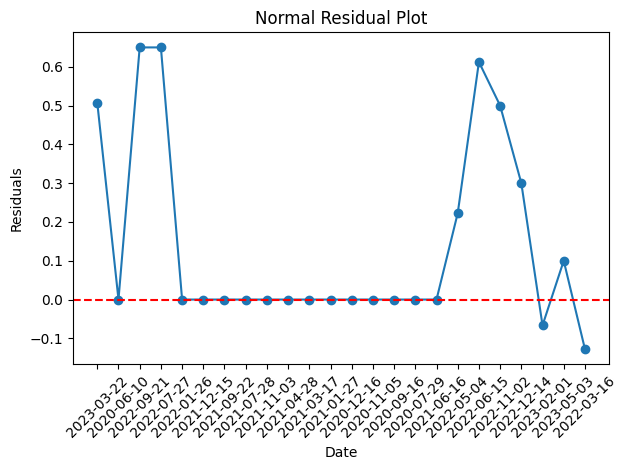

In [6]:
# Convert the lists to NumPy arrays
y_test = np.array(y_test)
best_y_test_pred = np.array(best_y_test_pred)

# Calculate the residuals (differences between predicted and true values)
residuals = y_test - best_y_test_raw

# Sort the residuals and 'Date' based on the predicted values
sorted_indices = best_y_test_pred.argsort()
sorted_residuals = residuals[sorted_indices]
sorted_dates = test['Date'].iloc[sorted_indices]

# Create the residual plot with sorted residuals and 'Date' on the x-axis
plt.plot(sorted_dates, sorted_residuals, marker='o')
plt.axhline(y=0, color='r', linestyle='--')  # Add a red dashed line at y=0 for reference
plt.xlabel("Date")
plt.ylabel("Residuals")
plt.title("Normal Residual Plot")
plt.xticks(rotation=45)  # Rotate x-axis labels for better readability
plt.tight_layout()  # Adjust layout to prevent clipping of labels
plt.show()

In [7]:
data = {
    'Date': test['Date'],
    'True Values (y_test)': y_test,
    'Predicted Values (best_y_test_pred)': best_y_test_pred,
    'Raw Predicted Values (best_y_test_raw)': best_y_test_raw,
    'Residuals': residuals
}

df = pd.DataFrame(data)

# Display the table
print(df)

          Date  True Values (y_test)  Predicted Values (best_y_test_pred)  \
0   2020-06-10                  0.00                                 0.00   
1   2020-07-29                  0.00                                 0.00   
2   2020-09-16                  0.00                                 0.00   
3   2020-11-05                  0.00                                 0.00   
4   2020-12-16                  0.00                                 0.00   
5   2021-01-27                  0.00                                 0.00   
6   2021-03-17                  0.00                                 0.00   
7   2021-04-28                  0.00                                 0.00   
8   2021-06-16                  0.00                                 0.00   
9   2021-07-28                  0.00                                 0.00   
10  2021-09-22                  0.00                                 0.00   
11  2021-11-03                  0.00                                 0.00   

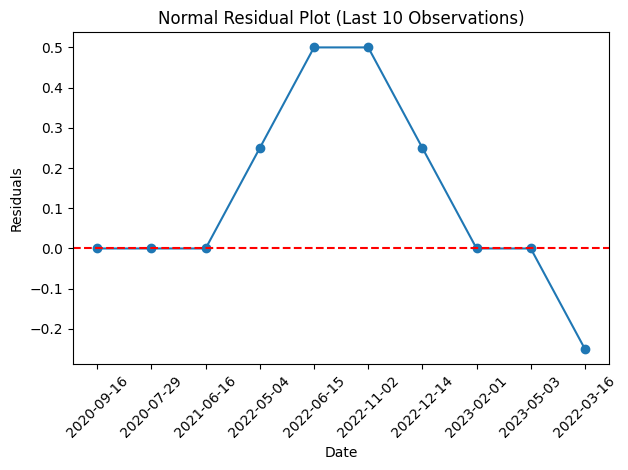

In [8]:
# Convert the lists to NumPy arrays
y_test = np.array(y_test)
best_y_test_pred = np.array(best_y_test_pred)

# Calculate the residuals (differences between predicted and true values)
residuals = y_test - best_y_test_pred

# Sort the residuals and 'Date' based on the predicted values
sorted_indices = best_y_test_pred.argsort()
sorted_residuals = residuals[sorted_indices]
sorted_dates = test['Date'].iloc[sorted_indices]

# Select the last 10 observations
last_10_residuals = sorted_residuals[-10:]
last_10_dates = sorted_dates[-10:]

# Create the residual plot with last 10 observations and 'Date' on the x-axis
plt.plot(last_10_dates, last_10_residuals, marker='o')
plt.axhline(y=0, color='r', linestyle='--')  # Add a red dashed line at y=0 for reference
plt.xlabel("Date")
plt.ylabel("Residuals")
plt.title("Normal Residual Plot (Last 10 Observations)")
plt.xticks(rotation=45)  # Rotate x-axis labels for better readability
plt.tight_layout()  # Adjust layout to prevent clipping of labels
plt.show()